In [83]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_symmetric
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering, k_means
from sklearn.manifold import spectral_embedding

from graspologic.plot import adjplot
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed   
from graspologic.utils import remap_labels, is_symmetric
from graspologic.simulations import sbm

from tqdm import tqdm

In [84]:
n_sims = 50
n_verts = [100, 500, 1000, 2000, 3000, 4000, 5000]

#n_sims = 5
#n_verts = [10, 25, 50, 100, 500, 1000]

B_aff = np.array([[0.050, 0.013], [0.013, 0.051]])
B_core = np.array([[0.011, 0.027], [0.027, 0.079]])

In [85]:
def calc_ari(B, embed_method):
    rows = []
    
    #progress bar for the outer loop over n_verts
    for n in tqdm(n_verts, desc="Vertices"):
        # Generate the true labels
        labels_sbm = n * [0] + n * [1]

        #generate the sbm
        sampled_sbm = sbm(2 * [n], B, directed=True)

        #progress bar for the inner loop over simulations
        for _ in tqdm(range(n_sims), desc="Simulations", position=1, leave=True):
            # Choose embedding method
            if embed_method == "ase":
                ase = AdjacencySpectralEmbed(n_components=2)
                Xhat, Yhat = ase.fit_transform(sampled_sbm)
            elif embed_method == "lse":
                lse = LaplacianSpectralEmbed(n_components=2)
                Xhat, Yhat = lse.fit_transform(sampled_sbm)
            elif embed_method == "sklearn":
                Xhat = spectral_embedding(sampled_sbm, n_components=2)


            #concatenate Xhat and Yhat if using ase or lse
            if embed_method == "ase" or embed_method == "lse":
                Xhat = np.concatenate((Xhat, Yhat), axis=1)

            #calculate the ARI score
            labels_kmeans = KMeans(n_clusters=2).fit_predict(Xhat)
            ari = adjusted_rand_score(labels_sbm, labels_kmeans)
            result = {
                "test": embed_method,
                "n_vert": n,
                "ari": ari
            }
            rows.append(result)
        print(n)

    results = pd.DataFrame(rows)
    return results

In [86]:
#lse vs sklearn (use B_aff)
ari_aff_lse_df = calc_ari(B = B_aff, embed_method = "lse")
#ari_aff_ase_df = calc_ari(B = B_aff, embed_method = "ase")
ari_aff_sklearn_df = calc_ari(B = B_aff, embed_method = "sklearn")
ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_sklearn_df])
#ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_ase_df, ari_aff_sklearn_df])
ari_aff_df.to_csv("ari_aff_df.csv")

Vertices:  14%|█▍        | 1/7 [00:05<00:30,  5.11s/it]

100


Vertices:  29%|██▊       | 2/7 [00:24<01:07, 13.49s/it]

500


Vertices:  43%|████▎     | 3/7 [01:45<02:57, 44.37s/it]

1000


Vertices:  57%|█████▋    | 4/7 [09:02<09:58, 199.40s/it]

2000


Vertices:  71%|███████▏  | 5/7 [28:54<18:34, 557.37s/it]

3000


Vertices:  86%|████████▌ | 6/7 [1:11:14<20:31, 1231.46s/it]

4000


Vertices: 100%|██████████| 7/7 [2:28:39<00:00, 1274.21s/it]


5000


Vertices:   0%|          | 0/7 [00:00<?, ?it/s]/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neur

100


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

500


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

1000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

2000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

3000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

4000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

5000


In [87]:
#get the means across the sims (groupby test and n_vert)
ari_aff_means = ari_aff_df.groupby(["test", "n_vert"]).mean()
ari_aff_means

ari
test    n_vert          
lse     100     0.791051
        500     1.000000
        1000    1.000000
        2000    1.000000
        3000    1.000000
        4000    1.000000
        5000    1.000000
sklearn 100     0.921204
        500     0.960307
        1000    0.861461
        2000    0.840090
        3000    0.960129
        4000    1.000000
        5000    0.940210

Text(0.5, 1.0, 'ARI of Affinity Graph using Different Embedding Methods')

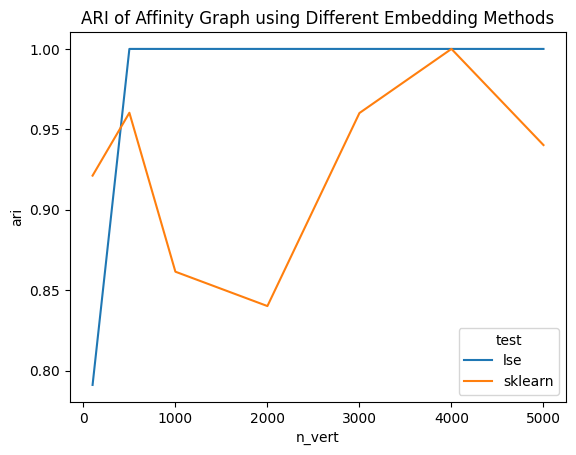

In [88]:
#make lse vs sklearn affinity plot
sns.lineplot(data=ari_aff_means, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Affinity Graph using Different Embedding Methods')

In [89]:
#ase vs sklearn (use B_core)
ari_core_ase_df = calc_ari(B = B_core, embed_method = "ase")
#ari_core_lse_df = calc_ari(B = B_core, embed_method = "lse")
ari_core_sklearn_df = calc_ari(B = B_core, embed_method = "sklearn")
ari_core_df = pd.concat([ari_core_ase_df, ari_core_sklearn_df])
#ari_core_df = pd.concat([ari_core_ase_df, ari_core_lse_df, ari_core_sklearn_df])
ari_core_df.to_csv("ari_core_df.csv")

Vertices:  14%|█▍        | 1/7 [00:01<00:09,  1.58s/it]

100


Vertices:  29%|██▊       | 2/7 [00:15<00:43,  8.76s/it]

500


Vertices:  43%|████▎     | 3/7 [00:55<01:33, 23.29s/it]

1000


Vertices:  57%|█████▋    | 4/7 [03:54<04:13, 84.61s/it]

2000


Vertices:  71%|███████▏  | 5/7 [11:45<07:27, 223.89s/it]

3000


Vertices:  86%|████████▌ | 6/7 [23:31<06:27, 387.91s/it]

4000


Vertices: 100%|██████████| 7/7 [44:55<00:00, 385.05s/it]


5000


Vertices:   0%|          | 0/7 [00:00<?, ?it/s]/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neur

100


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

500


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

1000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

2000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

3000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

4000


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

5000


In [90]:
#get the means across the sims (groupby test and n_vert)
ari_core_means = ari_core_df.groupby(["test", "n_vert"]).mean()
ari_core_means

ari
test    n_vert          
ase     100     0.331369
        500     1.000000
        1000    1.000000
        2000    1.000000
        3000    1.000000
        4000    1.000000
        5000    1.000000
sklearn 100     0.001477
        500     0.017238
        1000    0.000354
        2000    0.007483
        3000    0.000277
        4000    0.003098
        5000    0.075179

Text(0.5, 1.0, 'ARI of Core Periphery Graph using Different Embedding Methods')

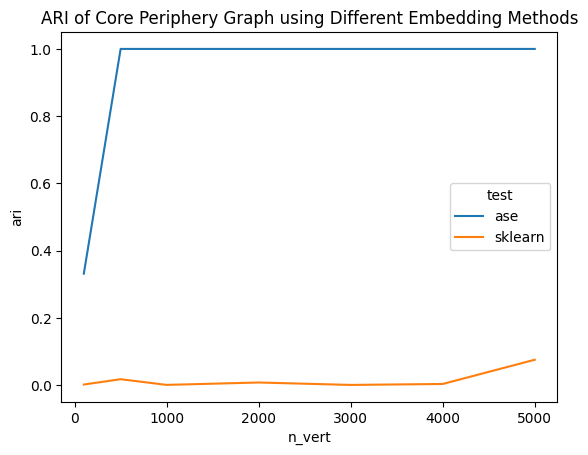

In [91]:
#make ase vs sklearn core periphery plot
sns.lineplot(data=ari_core_means, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Core Periphery Graph using Different Embedding Methods')